In [132]:
import cobra
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit

import refinegems

## Fix problem with Infeasible Error in get_secretion

In [66]:
#model = cobra.io.load_model('iJO1366')

testpath = "/Users/brune/Downloads/iAF692.xml"
model = refinegems.utility.io.load_model(testpath,'cobra')

In [67]:
with model:

    sf = model.summary().secretion_flux
    s = sf[sf['flux'] < 0.0].index.tolist()

    print(s)

['EX_ch4_e', 'EX_ch4s_e', 'EX_co2_e', 'EX_gcald_e', 'EX_gly_e', 'EX_h2o_e', 'EX_h_e', 'EX_unknown_rbfdeg_e']


In [68]:
model.optimize()

,fluxes,reduced_costs
ASPCT,0.009144,1.387779e-17
ASPK,0.034231,-1.387779e-17
ASPTA,-0.079818,4.751337e-18
ASPTRS,0.000000,4.163336e-17
ATGH,0.000018,-1.942890e-16
...,...,...
VALt2r,0.000000,-1.252600e-18
VOR,0.000000,3.320615e-18
XPPT,0.000000,-3.874205e-02
YUMPS,0.000000,-0.000000e+00


## Deal with external media

In [2]:
from refinegems.classes.medium import read_substances_from_file, read_external_medium

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [3]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/media-test/test.tsv'
subs = read_substances_from_file(filepath)
subs

,name,formula,flux,source,BiGG,VMH
0,Water,H2O,10.0,water,h20,h20


In [5]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/media-test/test.tsv'
medium = read_external_medium('file', path=filepath)
medium

In [10]:
medium.substance_table

,name,formula,flux,source,BiGG,VMH
0,Water,H2O,10.0,water,h20,h20


## Build growth curves from data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit

In [2]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate1.tsv'
filepath1 = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate2.tsv'
filepath2 = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate3.tsv'
filepaths = [filepath,filepath1,filepath2]

In [3]:
def extract_test_info(df):
    test_info = dict()
    blanks = dict()
    test_cell = df.columns[1:]
    used_medium = df.iloc[0,1:]
    tested_strain = df.iloc[1,1:]
    for t,m,s in zip(test_cell,used_medium,tested_strain):
        if 'blank' == s:
            if m in blanks.keys():
                blanks[m].append(t)
            else:
                blanks[m] = [t]
        else:
            temp = str(m)+'_'+str(s)
            if temp in test_info.keys():
                test_info[temp].append(t) 
            else:
                test_info[temp] = [t]
    return test_info,blanks


def convert_table(df, timeinterval=15):

    # drop unneeded columns
    df.drop(df.columns[2],axis=1,inplace=True) # drop temperature
    df.drop(df.columns[0],axis=1,inplace=True) # drop first column

    # extract cell information
    info,blanks = extract_test_info(df)

    # drop extracted information
    df.drop(df.index[0],axis=0,inplace=True) 
    df.drop(df.index[0],axis=0,inplace=True)

    # adjust time 
    timecol = [timeinterval*_ for _ in range(0,len(df.index),1)]
    df.index = timecol
    df.drop(df.columns[0],axis=1,inplace=True)

    # calculate mean of blanks
    df = df.apply(pd.to_numeric)
    for btype,blist in blanks.items():
        df[btype] = df[blist].mean(axis=1)
        df.drop(blist,axis=1,inplace=True)

    # baseline correction
    for condition,positions in info.items():
        m = condition.split('_')[0]
        for p in positions:
            df[p] = df[p]-df[m]

    # remove blanks
    df.drop(blanks.keys(),axis=1,inplace=True)

    return df,info

def read_in_experiments(filepaths, timeinterval=15, skiprows=51):  # maybe quarks for read_csv

    info = dict()
    data = 0

    # read in all test data
    for idx in range(0,len(filepaths)):
        # read in the new table
        current = pd.read_csv(filepath, sep='\t', skiprows=skiprows)
        suffix = str(idx)
        current.rename(columns={c:c+'_'+suffix for c in list(current.columns)}, inplace=True)
        # covert table into correct format + baseline correction
        current_data,current_info = convert_table(current,timeinterval)
        # concat data
        if isinstance(data,pd.DataFrame):
            for k,v in current_info.items():
                if k in info.keys():
                    info[k] = info[k]+current_info[k]
                else:
                    # Should not happen - maybe print a warning?
                    info[k] = current_info
            data = pd.concat([data,current_data],axis=1)
        else:
            info = current_info
            data = current_data

    return data,info

def calculate_bio_mean(data_table, data_info):

    means = dict()
    stdevs = dict()

    # calculate the mean over the replicates
    for condition,positions in data_info.items():
        means[condition] = data_table[positions].mean(axis=1)
        stdevs[condition] = data_table[positions].std(axis=1)

    means = pd.DataFrame(means)
    stdevs = pd.DataFrame(stdevs)

    return means,stdevs


In [4]:
data,info = read_in_experiments(filepaths)
dmean, dstd = calculate_bio_mean(data,info)

In [5]:
def gompertz_model(t,a,b,c): #based on Franses94
    return a*np.exp(-b*np.exp(-c*t))

def fourparam_gompertz_model(t,a,b,ku,ti): 
    return b+((a-b)*np.exp(-np.exp(-ku*(t-ti))))

def logistic_mod(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

In [162]:
def fit_growth_curve(dmean,dstd,fit,col,perc=None):

    # idea:
    # get indx at max 
    # get index at first position with condition idx > idx_max & value < x% max
    # only take values with values smaller than the idx calculated above 
    # (if result else take all)

    xdata = dmean.index
    ydata = dmean.iloc[:,col]
    errdata = dstd.iloc[:,col]
    cutoff = None
    if perc:
        max_point = (dmean.iloc[:,col].idxmax(), dmean.iloc[:,col].max())
        temp = dmean.iloc[:,col][(dmean.index > max_point[0]) & (dmean.iloc[:,col] < perc*max_point[1])]
        if len(temp) > 0:
            cutoff = temp.index[0]
            xdata = dmean.index[dmean.index < cutoff]
            ydata = dmean.iloc[dmean.index < cutoff,col]
            errdata = dstd.iloc[dmean.index < cutoff,col]        

    match fit:

        case 'gompertz4':
            solution = curve_fit(fourparam_gompertz_model, xdata, 
                                 ydata, sigma=errdata, method='lm', 
                                 p0=np.asarray([0.2,0.005,0.05,0.05])) #p0=np.asarray([0.2,0.005,0.05,30]) 

        case 'logistic':
            solution = curve_fit(logistic_mod, xdata, ydata, 
                                 sigma=errdata, method='lm', 
                                 p0=np.asarray([0.2,0.005,0.05])) #p0=np.asarray([0.2,0.005,0.05,30]) 

    return cutoff,solution

In [163]:
def plot_growth_curves(dmean,dstd,solu, cutoff, col, fit):

    # plot the mean data points
    plt.scatter(x=list(dmean.index),
                y=list(dmean.iloc[:,col]),
                marker='.'
                )
    # plots the error bars
    plt.errorbar(x=list(dmean.index),
                y=list(dmean.iloc[:,col]),
                xerr=dstd.iloc[:,col],
                yerr=dstd.iloc[:,col],
                fmt='none',
                alpha=0.5
                )
    
    # filter data for fit, if cutoff was set
    if cutoff:
        xdata = list(dmean.index[dmean.index < cutoff])
    else:
        xdata = list(dmean.index)

    # visualise the fit
    match fit:
        
        case 'gompertz4':
            plt.plot(xdata,
                     [fourparam_gompertz_model(point,solu[0][0],solu[0][1],solu[0][2],solu[0][3]) for point in xdata],
                    color='red')
            
        case 'logistic':
            plt.plot(xdata,
                     [logistic_mod(point,solu[0][0],solu[0][1],solu[0][2]) for point in xdata],
                    color='red')
    

RPMI_147
192.0428474846806


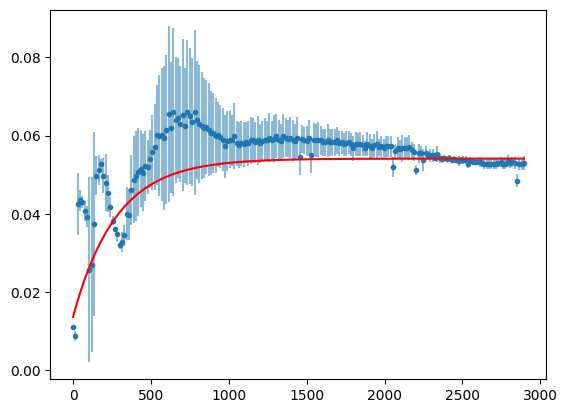

In [164]:
x = 5
#fit = 'logistic'
fit = 'gompertz4'
cut, solu = fit_growth_curve(dmean,dstd,fit,x,None)
print(dmean.columns[x])
print(np.log(2)/(solu[0][2]))
plot_growth_curves(dmean,dstd,solu,cut,x,fit)

# Problem with Stats Report

a) Number of GPR reactions differs from Memote. Reason: Exchange reactions - how and where to cover them.

- separate gpr for normal and pseudoreaction (sinks,exchanges,demand,growth)
- idea: pie/donut chart?

b) (un)balanced reactions graphic 
    
- percentage maybe better
- donut/pie chart 

c) re-check report: maybe save IDs for unbalanced, gpr etc.?

In [1]:
from refinegems.utility.io import load_model

import cobra

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [3]:
p = '/Users/brune/Downloads/iSpasFDAARGOS_1151tw2024.xml'

model = load_model(p,'cobra')

Adding exchange reaction EX_2hxmp_e with default bounds for boundary metabolite: 2hxmp_e.
Adding exchange reaction EX_2mbald_e with default bounds for boundary metabolite: 2mbald_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3gmp_e with default bounds for boundary metabolite: 3gmp_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4ahmmp_e with default bounds for boundary metabolite: 4ahmmp_e.
Adding exchange reaction EX_4hba_e with default bounds for boundary metabolite: 4hba_e.
Adding exchange reaction EX_5drib_e with default bounds for boundary metabolite: 5drib_e.
Adding exchange reaction EX_LalaLglu_e with default bounds for boundary metabolite: LalaLglu_e.
Adding exchange reaction EX_acald_e with default bounds for boundary metabolite: acald_e.
Adding exchange reaction EX_acgam_e with default bounds for boundary metabolite: acgam_e.
Adding e

In [6]:
reac_with_gpr = 0
our_res = set()
for reac in model.reactions:
    # check for GPR
    if len(reac.genes) > 0:
        our_res.add(reac.id)
        reac_with_gpr += 1

In [7]:
memote_res = ["ETHAt","UAGPT2","2AGPG120tipp","Clt","PAP_BS","FAD_14","SR5","CATECHOLtex","FCLT_2","PPALtpp","DARBabcpp","2AGPE160tipp","NH4OHDs","GTPCI","PPAKr","4HBAt","DAGK160","MANAO","PPAP_Et","QMO2","2HXMPt6","RAFFINt2","DAAD4","2AGPG140tipp","PLCD","2AGPE180tipp","LIPO4S24_BS","OCDCEAt2pp","PPALtex","QMO3","HYPOE","FA120ACPHi","IPMD2","ARGtex","Growth","LAAL1","ATPM","CRO4t3pp","2AGPE120tipp","3HAACOAT120","PLIPA1G160pp","BUTCT","2AGPG141tipp","PPTGS_BS","NP1","GLYCTO3","PLIPA1G161pp","TRSARr","3GMPtex_1","2AGPG160tipp","SALCt","ADPGLC","PLIPA1G180pp","HDCAt2pp","ARAB_Lt","CDAPPA161","2AGPE141tipp","2MBALDt","LYStex","2AGPG161tipp","ASO4rt2rpp","FACOAE141","PLIPA1G181pp","DHPt","PAPA120pp","PLIPA1E141pp","2AGPG180tipp","PLIPA1E120pp","LIPO1S24_BS","LIPO3S24_BS","OPP","TAURabc","3UMPt6","FADE233","DAGK120","TMPK","ARAI","2AGPG181tipp","G3POA_BS","MNtex","CAt6","2AGPE181tipp","NTD12","CATECHOLtpp","PItex","ADAPAT","CELBpts","2AGPGAT120","ACMUMptspp","FACOAL120t2pp","DSERtex","MANE","ASO4tex","2AGPEAT120","LIPO2S24_BS","CITtex","FORAMD","FE3PYOVD2tonex","HQNt6","2AGPGAT140","MALTt2","ARAB_Dt","TOLtpp","3CMPt6","MECDPDH","2AGPEAT141","PIt7ipp","BALAtex","2AGPGAT181","DAGK161","PACALDt","DAGK141","2AGPGAT141","FE3PYOVDDR2","SO3tex","2AGPEAT160","MECDPS","CDAPPA120","MELIBtex","ALCDpp","BTNTe","CGLYtex","PYDXPP","UAAGDS","DXPRIi","ACOAD5","Cuabc","LCTStpp","ACMUMtex","FACOAL161t2pp","GLXCL","PSUDS","AGPATr_BS","FACOAL141t2pp","ORNtex","AACPS9","DAGK180","DXPS","GLUt4pp","2AGPGAT160","FAO11","2AGPEAT180","CDAPPA140","ARBabcpp","PLIPA1G120pp","DAGK181","CDPPT160","SPT_syn","PLIPA1G140pp","BTCOARx","PAPPT3","2AGPGAT180","AMMQLT8","ALAtpp","DHNAOT4","GLYtpp","4HTHRK","ALDR","DRIBtex_1","SUCRt2","UAG4Ei","NADH16pp","FE3tex","PAP","SBTPD","CDAPPA180","UGT_BS","12DGR180tipp","OXADC","RU5PP","12DGR120tipp","RECOAH5","2AGPGAT161","12DGR141tipp","RHA40tpp","SPMDt3i","2AGPEAT181","PTRCtex","3M2OPLOXRD","12DGR181tipp","GDPTPDP","CDAPPA181","PAPA161pp","PAPA180pp","ALAGLUabcpp","PTRCORNt7","LALALGLUtex","TMAMt","AMANAPEr","UAGPT3","GALUR_Et","TTDCAt2pp","DALAtex","OXGDC2","NACt","MTAM_1","PAPA141pp","PAPA181pp","PLIPA1E160pp","MS_1","MAN6Pt6_2","METtex","12DGR161tipp","PTRCTA","KGD2","PLIPA1E181pp","OCDCAt2pp","PLIPA1G141pp","ACGLUtd","FDMO4_1","PLIPA1E180pp"]

memote_res = set(memote_res)      

In [8]:
our_res.intersection(memote_res)

set()

In [9]:
[_ for _ in our_res if _ in memote_res]

[]

In [15]:
intersec = our_res.union(memote_res)

In [16]:
remains = [_ for _ in model.reactions if _.id not in intersec]

In [20]:
len(remains)-3

174

In [19]:
len(model.exchanges)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


174

idea: change graphic for gpr, include information about exhange/sink etc       
problem: what to do with the unbalanced? does not look nice

# The thing with gapfilling

In [1]:
import refinegems as rg
from refinegems.curation.db_access.kegg import parse_KEGG_gene
from refinegems.utility.io import parse_gff_for_gp_info
from libsbml import Model as libModel
import pandas as pd
from bioservices.kegg import KEGG
import io
import re

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
mpath = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
gffpath = '/Users/brune/Downloads/ncbi_dataset/ncbi_dataset/data/GCF_000240185.1/genomic.gff'

model = rg.utility.io.load_model(mpath,'libsbml')

In [3]:
class KEGGapFiller():

    def __init__(self, organismid) -> None:
        #super().__init__()
        self.organismid = organismid
        
    def get_missing_genes(self, model:libModel):
    
        # Function originally from refineGEMs.genecomp/refineGEMs.KEGG_analysis/entities --- Modified
        def get_model_genes(model: libModel) -> pd.DataFrame:
            """Extracts KEGG Genes from given model

            Args:
                - model (model-libsbml): 
                    Model loaded with libSBML

            Returns:
                pd.DataFrame: 
                    Table with all KEGG Genes in the model
            """
            genes_in_model = []
            for gene in model.getPlugin(0).getListOfGeneProducts():
                cv_terms = gene.getCVTerms()
                if cv_terms:
                    for cv_term in cv_terms:
                        for idx in range(cv_term.getNumResources()):
                            uri = cv_term.getResourceURI(idx)
                            if 'kegg.genes' in uri: 
                                genes_in_model.append(re.split('kegg.genes:|kegg.genes/',uri)[1]) # work with olf/new pattern

            return pd.DataFrame(genes_in_model, columns=['orgid:locus'])
        
        # Step 1: get genes from model
        genes_in_model = get_model_genes(model)
        
        # Step 2: get genes of organism from KEGG
        gene_KEGG_list = KEGG().list(self.organismid)
        gene_KEGG_table = pd.read_table(io.StringIO(gene_KEGG_list), header=None)
        gene_KEGG_table.columns = ['orgid:locus','CDS','position','protein']
        gene_KEGG_table = gene_KEGG_table[['orgid:locus']]
        
        # Step 3: KEGG vs. model genes -> get missing genes for model
        genes_not_in_model = gene_KEGG_table[~gene_KEGG_table['orgid:locus'].isin(genes_in_model['orgid:locus'])]
        
        # Step 4: extract locus tag
        genes_not_in_model['locus_tag'] = genes_not_in_model['orgid:locus'].str.split(':').str[1]
        
        # Step 6: map to EC via KEGG
        subset_genes = genes_not_in_model.iloc[345:350,:] # @DEBUG
        geneKEGG_mapping = pd.DataFrame.from_dict(list(subset_genes['orgid:locus'].apply(parse_KEGG_gene)))
        subset_genes = subset_genes.merge(geneKEGG_mapping, how='left', on='orgid:locus')
        
        # @TODO : What to report where and when
        # self.report['missing genes (total)'] = len(genes_not_in_model)
        
        return subset_genes 
    
    

In [4]:
kpf = KEGGapFiller('kpm')
gene_table = kpf.get_missing_genes(model)

In [5]:
gene_table

,orgid:locus,locus_tag,kegg.orthology,ec-code,ncbigene,ncbiprotein
0,kpm:KPHS_p300480,KPHS_p300480,[K03196],[7.4.2.8],11817791,YP_005220996
1,kpm:KPHS_p300490,KPHS_p300490,NaN,NaN,11817792,YP_005220997
2,kpm:KPHS_p300500,KPHS_p300500,NaN,NaN,11817793,YP_005220998
3,kpm:KPHS_p300510,KPHS_p300510,[K03892],NaN,11817794,YP_005220999
4,kpm:KPHS_p300520,KPHS_p300520,[K18320],NaN,11817795,YP_005221000


In [17]:
reacs_idea = gene_table[['ec-code','ncbiprotein']].dropna()
eccode = reacs_idea['ec-code'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
ncbiprot = reacs_idea['ncbiprotein'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
reacs_idea = pd.merge(eccode,ncbiprot,left_index=True, right_index=True).rename(columns={'value_x':'ec-code','value_y':'ncbiprotein'})
reacs_idea.groupby(reacs_idea['ec-code']).aggregate({'ncbiprotein':'unique'}).reset_index()

,ec-code,ncbiprotein
0,7.4.2.8,[YP_005220996]


Possible information to retrieve:

- Annotations:

    - Motif -> pfam
    - DBlinks -> multiple, e.g. ncbiprotein, ncbigene, uniprot
    - orthology -> EC

- Name 

In [20]:
# write a better parser to retain more information, as the lookup is done anyways?
k = KEGG()
kegg_ec_test = k.parse(k.get('7.4.2.8'))

In [21]:
kegg_ec_test

{'ENTRY': 'EC 7.4.2.8                  Enzyme',
 'NAME': ['protein-secreting ATPase'],
 'CLASS': 'Translocases;             Catalysing the translocation of amino acids and peptides;             Linked to the hydrolysis of a nucleoside triphosphate',
 'SYSNAME': 'ATP phosphohydrolase (protein-secreting)',
 'REACTION': ['ATP',
  '+',
  'H2O',
  '+',
  'cellular',
  'protein[side',
  '1]',
  '=',
  'ADP',
  '+',
  'phosphate',
  '+',
  'cellular',
  'protein[side',
  '2]'],
 'SUBSTRATE': ['ATP [CPD:C00002];',
  'H2O [CPD:C00001];',
  'cellular protein[side 1]'],
 'PRODUCT': ['ADP [CPD:C00008];',
  'phosphate [CPD:C00009];',
  'cellular protein[side 2]'],
 'COMMENT': ['A non-phosphorylated, non-ABC (ATP-binding cassette) ATPase that is involved in protein transport. There are several families of enzymes included here, e.g. ATP-hydrolysing enzymes of the general secretory pathway (Sec or Type II), of the virulence-related secretory pathway (Type III) and of the conjugal DNA-protein transfer

Possible Information to retrieve:

- name(s)
- reaction equation
- metabolite (names and possibly KEGG ID)
- Annotations:

    - Orthology -> kegg.orthology
    - DBlinks -> multiple, e.g. brenda, 



In [26]:
mnx_reac_prop_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/data/MetaNetX/reac_prop.tsv'

reac_prop = pd.read_csv(mnx_reac_prop_path, sep='\t', comment='#', names=['ID','mnx equation','reference','classifs','is_balanced','is_transport'])

### Add MNX to database

In [80]:
import requests
import sqlite3
from refinegems.utility.databases import PATH_TO_DB

# DISCLAIMER:
# Database information from MetaNetX
# distributed under https://creativecommons.org/licenses/by/4.0/
# Citation: MetaNetX/MNXref: unified namespace for metabolites and biochemical reactions in the context of metabolic models
#           Sébastien Moretti, Van Du T Tran, Florence Mehl, Mark Ibberson, Marco Pagni
#           Nucleic Acids Research (2021), 49(D1):D570-D574

mnx_db_namespace = {'reac_prop': ('https://www.metanetx.org/cgi-bin/mnxget/mnxref/reac_prop.tsv', 
                                  ['id','mnx_equation','reference','ec-code','is_balanced','is_transport']),
                    'reac_xref': ('https://www.metanetx.org/cgi-bin/mnxget/mnxref/reac_xref.tsv',
                                  ['source','id','description']),
                    'chem_prop': ('https://www.metanetx.org/cgi-bin/mnxget/mnxref/chem_xref.tsv',
                                  ['id','name','reference','formula','charge','mass','InChI','InChIKey','SMILES']),
                    'chem_xref': ('https://www.metanetx.org/cgi-bin/mnxget/mnxref/chem_prop.tsv',
                                  ['source','id','description'])
                    }


def update_mnx_namespaces(db_connection):
    for name,values in mnx_db_namespace.items():
        link,colnames = values
        mnx_table = pd.read_csv(link, sep='\t', comment='#', names=colnames)
        
        match name:
            # Reaction property table
            case 'reac_prop':
                mnx_table.to_sql(
                    'mnx_'+name, db_connection, 
                    if_exists='replace', index=False, 
                    dtype={'id':'TEXT PRIMARY KEY'}
                    )
            # Reaction cross-reference table
            case 'reac_xref':
                cursor = db_connection.cursor()
                cursor.execute('DROP TABLE IF EXISTS mnx_reac_xref')
                empty_table = """ CREATE TABLE mnx_reac_xref (
                                  source TEXT,
                                  id TEXT,
                                  description TEXT,
                                  CONSTRAINT PK_mnx_reac_xref PRIMARY KEY (source,id)
                                  FOREIGN KEY(id) REFERENCES mnx_reac_prop(id)
                              );
                              """
                cursor.execute(empty_table)
                mnx_table.to_sql(
                    'mnx_'+name, db_connection, 
                    if_exists='append', index=False
                    )
            # Metabolite property table
            case 'chem_prop':
                mnx_table.to_sql(
                    'mnx_'+name, db_connection, 
                    if_exists='replace', index=False, 
                    dtype={'id':'TEXT PRIMARY KEY'}
                    )
            # Metabolite cross-reference table
            case 'chem_xref':
                cursor = db_connection.cursor()
                cursor.execute('DROP TABLE IF EXISTS mnx_chem_xref')
                empty_table = """ CREATE TABLE mnx_chem_xref (
                                  source TEXT,
                                  id TEXT,
                                  description TEXT,
                                  CONSTRAINT PK_chem_reac_xref PRIMARY KEY (source,id)
                                  FOREIGN KEY(id) REFERENCES mnx_chem_prop(id)
                              );
                              """
                cursor.execute(empty_table)
                mnx_table.to_sql(
                    'mnx_'+name, db_connection, 
                    if_exists='append', index=False
                    )

In [81]:
con = sqlite3.connect(PATH_TO_DB)
update_mnx_namespaces(con)
con.close()

IntegrityError: UNIQUE constraint failed: mnx_chem_xref.source, mnx_chem_xref.id